In [1]:

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow import keras as K

2024-07-11 22:11:46.503092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 22:11:46.627411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 22:11:46.627535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 22:11:46.775421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 22:11:52.858640: W tensorflow/compiler/tf

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Path to the .npz file containing the processed images and labels
npz_file_path = '/home/afk/Documents/new/FQML/brain_tumor/processed_new/processed_data.npz'

# Load the .npz file
data = np.load(npz_file_path)
images = data['images']
labels = data['labels']

# Print shapes of loaded data
print(f"Loaded images shape: {images.shape}")
print(f"Loaded labels shape: {labels.shape}")

# Flatten the images from shape (3049, 2, 2) to (3049, 4)
flattened_images = images.reshape(images.shape[0], -1)
print(f"Flattened images shape: {flattened_images.shape}")

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Perform a stratified split
train_images, test_images, train_labels, test_labels = train_test_split(
    flattened_images, 
    encoded_labels, 
    test_size=0.3,  # 30% of the data for testing
    stratify=encoded_labels,  # Ensures proportional splits
    random_state=42  # For reproducibility
)

np_data_set = [{'image': img, 'label': lbl} for img, lbl in zip(flattened_images, encoded_labels)]


# Assign variables for train and test datasets
train_data = {'images': train_images, 'labels': train_labels}
test_data = {'images': test_images, 'labels': test_labels}

# Print the shapes of the training and test datasets
print(f"Training images shape: {train_data['images'].shape}")
print(f"Training labels shape: {train_data['labels'].shape}")
print(f"Test images shape: {test_data['images'].shape}")
print(f"Test labels shape: {test_data['labels'].shape}")

# Count the number of instances of each label in the training and test datasets
train_label_counts = np.bincount(train_data['labels'])
test_label_counts = np.bincount(test_data['labels'])

print("\nLabel counts in the training dataset:")
for i, count in enumerate(train_label_counts):
    print(f"Label {i}: {count} instances")

print("\nLabel counts in the test dataset:")
for i, count in enumerate(test_label_counts):
    print(f"Label {i}: {count} instances")


Loaded images shape: (3049, 2, 2)
Loaded labels shape: (3049,)
Flattened images shape: (3049, 4)
Training images shape: (2134, 4)
Training labels shape: (2134,)
Test images shape: (915, 4)
Test labels shape: (915,)

Label counts in the training dataset:
Label 0: 496 instances
Label 1: 998 instances
Label 2: 640 instances

Label counts in the test dataset:
Label 0: 212 instances
Label 1: 428 instances
Label 2: 275 instances


In [3]:
np.random.shuffle(np_data_set)

print("First 5 samples of encoded shuffled data:")
print(np_data_set[:5])

First 5 samples of encoded shuffled data:
[{'image': array([0.39215687, 0.47058824, 0.4       , 0.47843137], dtype=float32), 'label': 1}, {'image': array([0.5647059 , 0.47843137, 0.5803922 , 0.49019608], dtype=float32), 'label': 1}, {'image': array([0.5019608 , 0.4627451 , 0.5058824 , 0.47058824], dtype=float32), 'label': 1}, {'image': array([0.62352943, 0.5137255 , 0.64705884, 0.5529412 ], dtype=float32), 'label': 2}, {'image': array([0.4745098 , 0.44705883, 0.50980395, 0.43137255], dtype=float32), 'label': 1}]


In [32]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
#from qiskit import IBMQ
from qiskit.providers.basic_provider import BasicProvider


num_clients = 2   #5
num_epochs = 7  #25
max_train_iterations = 10
samples_per_epoch= 100
#backend = Aer.get_backend('aer_simulator')
backend = BasicProvider().get_backend("basic_simulator")


fl_avg_weight_range = [0.1, 1]


In [33]:
class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []

def split_dataset(num_clients, num_epochs, samples_per_epoch, train_data):
    clients = []
    for i in range(num_clients):
        client_data = []
        for j in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            client_data.append({'images': train_data['images'][start_idx:end_idx], 
                                'labels': train_data['labels'][start_idx:end_idx]})
        clients.append(Client(client_data))
    return clients


clients = split_dataset(num_clients, num_epochs, samples_per_epoch, train_data)
for idx, client in enumerate(clients):
    labels = client.data[0]['labels']  # Correctly access the 'labels' key
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"Client {idx}, Epoch 0 - Labels: {dict(zip(unique_labels, counts))}")

clients[0].data[0]['images'][:5], clients[0].data[0]['labels'][:5]


Client 0, Epoch 0 - Labels: {0: 30, 1: 42, 2: 28}
Client 1, Epoch 0 - Labels: {0: 27, 1: 50, 2: 23}


(array([[0.43529412, 0.5254902 , 0.43529412, 0.54901963],
        [0.5411765 , 0.5921569 , 0.5529412 , 0.627451  ],
        [0.50980395, 0.4627451 , 0.5019608 , 0.47058824],
        [0.5176471 , 0.4745098 , 0.5529412 , 0.50980395],
        [0.56078434, 0.47843137, 0.5921569 , 0.5058824 ]], dtype=float32),
 array([0, 2, 2, 1, 1]))

In [34]:
# Get the data for the first epoch of the first client
client_data_example = clients[0].data[0]

# Iterate over the images and labels
for i in range(5):
    # Access the ith image and label
    image = client_data_example['images'][i]
    label = client_data_example['labels'][i]
    
    print(f"Shape of image in data_point {i}: {image.shape}")
    print(f"Label for data_point {i}: {label}")


Shape of image in data_point 0: (4,)
Label for data_point 0: 0
Shape of image in data_point 1: (4,)
Label for data_point 1: 2
Shape of image in data_point 2: (4,)
Label for data_point 2: 2
Shape of image in data_point 3: (4,)
Label for data_point 3: 1
Shape of image in data_point 4: (4,)
Label for data_point 4: 1


In [35]:
import time

itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr}", end=' | ')
'''
def train(data, model = None):
  if model is None:
    num_features = len(data[0]["image"])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=partial(training_callback),
        sampler=BackendSampler(backend=backend),
        warm_start=True

    )
    model = vqc_model

  train_images = [data_point["image"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]

  # Convert the lists to NumPy arrays
  train_images = np.array(train_images)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train image Shape:", train_images.shape)
  print("Train Labels Shape:", train_labels.shape)

  print("Training Started")
  start_time = time.time()
  model.fit(train_images, train_labels)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_images, train_labels)
  test_score_q = model.score(test_images, test_labels)
  return train_score_q, test_score_q, model
'''
def train(data, model=None):
    # Ensure 'data' is a list of dictionaries with 'image' and 'label'
    if isinstance(data, list) and len(data) > 0 and 'image' in data[0] and 'label' in data[0]:
        train_images = [data_point["image"] for data_point in data]
        train_labels = [data_point["label"] for data_point in data]
    else:
        raise ValueError("Data must be a list of dictionaries with 'image' and 'label' keys.")
    
    # Convert the lists to NumPy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    # Print the shapes
    print("Train image Shape:", train_images.shape)
    print("Train Labels Shape:", train_labels.shape)

    # Create a new model if one is not provided
    if model is None:
        num_features = len(train_images[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=max_train_iterations)
        model = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=partial(training_callback),
            sampler=BackendSampler(backend=backend),
            warm_start=True
        )

    # Training
    print("Training Started")
    start_time = time.time()
    model.fit(train_images, train_labels)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

    # Scoring
    print(f"SCORING MODEL")
    train_score_q = model.score(train_images, train_labels)
    test_score_q = model.score(test_images, test_labels)

    return train_score_q, test_score_q, model




In [36]:
def getAccuracy(weights, test_num = 200):
        num_features = len(test_images[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=BackendSampler(backend=backend),
            initial_point = weights
        )
        vqc.fit(test_images[:25], test_labels[:25])
        return vqc.score(test_images[:test_num], test_labels[:test_num])

def create_model_with_weights(weights):
  num_features = len(test_images[0])
  feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
  ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
  optimizer = COBYLA(maxiter=max_train_iterations)
  vqc = VQC(
      feature_map=feature_map,
      ansatz=ansatz,
      optimizer=optimizer,
      sampler=BackendSampler(backend=backend),
      warm_start = True,
      initial_point  = weights,
      callback=partial(training_callback)
  )
  return vqc

In [37]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


In [38]:
import numpy as np

def sort_epoch_results(epoch_results):
    # Pair weights and test_scores together
    pairs = zip(epoch_results['weights'], epoch_results['test_scores'])

    # Sort the pairs based on test_scores
    sorted_pairs = sorted(pairs, key=lambda x: x[1])

    # Unzip the sorted pairs back into separate arrays
    sorted_weights, sorted_test_scores = zip(*sorted_pairs)

    # Create a new sorted dictionary
    sorted_epoch_results = {
        'weights': list(sorted_weights),
        'test_scores': list(sorted_test_scores)
    }

    return sorted_epoch_results
fl_avg_weight_range = [0.1, 1]

def scale_test_scores(sorted_epoch_results):
    min_test_score = sorted_epoch_results['test_scores'][0]
    max_test_score = sorted_epoch_results['test_scores'][-1]
    min_weight, max_weight = fl_avg_weight_range
    scaled_weights = [
        min_weight + (max_weight - min_weight) * (test_score - min_test_score) / (max_test_score - min_test_score)
        for test_score in sorted_epoch_results['test_scores']
    ]
    sorted_epoch_results['fl_avg_weights'] = scaled_weights
    return sorted_epoch_results

def calculate_weighted_average(model_weights, fl_avg_weights):
    weighted_sum_weights = []
    for index in range(len(model_weights[0])):
      weighted_sum_weights.append(0)
      weighted_sum_weights[index] = sum([(weights_array[index]* avg_weight) for weights_array, avg_weight  in zip(model_weights, fl_avg_weights)])/sum(fl_avg_weights)
    return weighted_sum_weights

def weighted_average(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)
  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)
  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch



def weighted_average_best_pick(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None, best_pick_cutoff = 0.5):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)

  new_weights = []
  new_test_scores = []
  new_fl_avg_weights = []

  for index, fl_avg_weight in enumerate(epoch_results['fl_avg_weights']):
      if fl_avg_weight >= best_pick_cutoff:
          new_weights.append(epoch_results['weights'][index])
          new_test_scores.append(epoch_results['test_scores'][index])
          new_fl_avg_weights.append(fl_avg_weight)

  # Update the epoch_results dictionary with the new lists
  epoch_results['weights'] = new_weights
  epoch_results['test_scores'] = new_test_scores
  epoch_results['fl_avg_weights'] = new_fl_avg_weights

  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch

def simple_averaging(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_weights = epoch_results['weights']
  averages = []
  # Iterate through the columns (i.e., elements at the same position) of the arrays
  for col in range(len(epoch_weights[0])):
      # Initialize a variable to store the sum of elements at the same position
      col_sum = 0
      for row in range(len(epoch_weights)):
          col_sum += epoch_weights[row][col]

      # Calculate the average for this column and append it to the averages list
      col_avg = col_sum / len(epoch_weights)
      averages.append(col_avg)

  return averages



In [39]:

fl_techniques = {
    'Averaging': simple_averaging,
    'Weighted_Averaging': weighted_average,
    'Best_Pick_Weighted_Averaging': weighted_average_best_pick
}
clients_2d_array = [[] for _ in range(len(fl_techniques))]

for index, (technique_name, _) in enumerate(fl_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_2d_array[index].append(client_copy)


clients_2d_array

[[<__main__.Client at 0x7f89d5215f10>, <__main__.Client at 0x7f89d52168d0>],
 [<__main__.Client at 0x7f89d5214920>, <__main__.Client at 0x7f89da18a240>],
 [<__main__.Client at 0x7f89da18aa50>, <__main__.Client at 0x7f89da188ec0>]]

In [40]:
global_model_weights = []
global_model_accuracy = []


'''
for outer_idx, clients in enumerate(clients_2d_array):
  technique_name = list(fl_techniques.keys())[outer_idx]
  technique_function = list(fl_techniques.values())[outer_idx]
  print(f"Technique Name: {technique_name}")
  global_model_weights.append([])
  global_model_accuracy.append([])
  for epoch in range(num_epochs):
    epoch_results = {
        'weights': [],
        'test_scores': []
    }
    print(f"epoch: {epoch}")

    for index, client in enumerate(clients):
      print(f"Index: {index}, Client: {client}")

      if client.primary_model is None:
        train_score_q, test_score_q, model = train(data = client.data[epoch])
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        # Print the values
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

      else:
        train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

    new_global_weights = []
    if(epoch == 0):
      new_global_weights = technique_function(epoch_results)
    else:
      new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
    print(new_global_weights)
    global_model_weights[outer_idx].append(new_global_weights)
    new_model_with_global_weights = create_model_with_weights(global_model_weights[outer_idx][epoch])

    for index, client in enumerate(clients):
      client.primary_model = new_model_with_global_weights

    global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch], len(test_images))
    global_model_accuracy[outer_idx].append(global_accuracy)
    print(f"Technique Name: {technique_name}")
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
    print("----------------------------------------------------------")
'''

for outer_idx, clients in enumerate(clients_2d_array):
    technique_name = list(fl_techniques.keys())[outer_idx]
    technique_function = list(fl_techniques.values())[outer_idx]
    print(f"Technique Name: {technique_name}")
    global_model_weights.append([])
    global_model_accuracy.append([])

    for epoch in range(num_epochs):
        epoch_results = {
            'weights': [],
            'test_scores': []
        }
        print(f"Epoch: {epoch}")

        for index, client in enumerate(clients):
            print(f"Index: {index}, Client: {client}")

            # Ensure correct format of data
            client_data = [{'image': img, 'label': lbl} for img, lbl in zip(client.data[epoch]['images'], client.data[epoch]['labels'])]

            if client.primary_model is None:
                train_score_q, test_score_q, model = train(data=client_data)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)
            else:
                train_score_q, test_score_q, model = train(data=client_data, model=client.primary_model)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)

        new_global_weights = []
        if epoch == 0:
            new_global_weights = technique_function(epoch_results)
        else:
            new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
        print(new_global_weights)
        global_model_weights[outer_idx].append(new_global_weights)
        new_model_with_global_weights = create_model_with_weights(global_model_weights[outer_idx][epoch])

        for index, client in enumerate(clients):
            client.primary_model = new_model_with_global_weights

        global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch], len(test_images))
        global_model_accuracy[outer_idx].append(global_accuracy)
        print(f"Technique Name: {technique_name}")
        print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
        print("----------------------------------------------------------")



Technique Name: Averaging
Epoch: 0
Index: 0, Client: <__main__.Client object at 0x7f89d5215f10>
Train image Shape: (100, 4)
Train Labels Shape: (100,)
Training Started


1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 
Training complete. Time taken: 8.354113340377808 seconds.
SCORING MODEL
Train Score: 0.42
Test Score: 0.3989071038251366



Index: 1, Client: <__main__.Client object at 0x7f89d52168d0>
Train image Shape: (100, 4)
Train Labels Shape: (100,)
Training Started
11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
Training complete. Time taken: 9.880106925964355 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.473224043715847



[0.28534023165800554, 1.7262092532235136, 1.3024340517218878, 0.5888636769234008, 1.01567913408338, 0.5894709501193733, 1.002038047638017, 1.1696467956927803, 0.49535391223497205, 0.6866432382768919, 0.01005708527613014, 0.8807030758804185, 0.48200422726866615, 0.22115154320100489, 0.4930797872386063, 0.27501106245875745]
Technique Name: Averaging
Global Model Accuracy In Epoch 0: 0.4360655737704918
----------------------------------------------------------
Epoch: 1
Index: 0, Client: <__main__.Client object at 0x7f89d5215

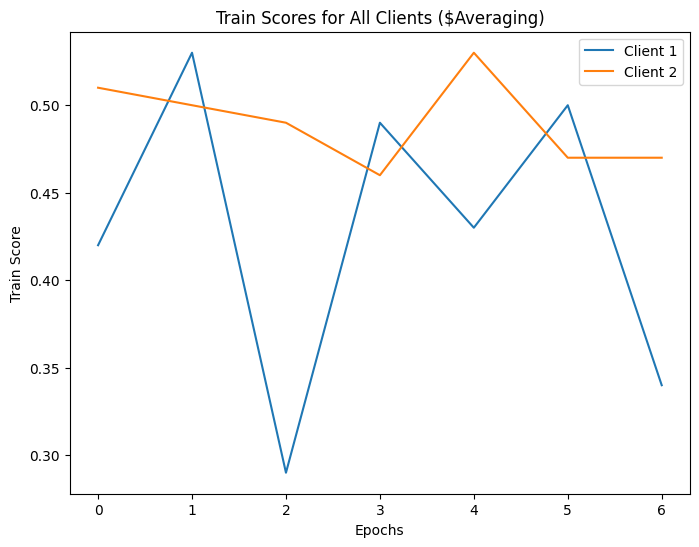

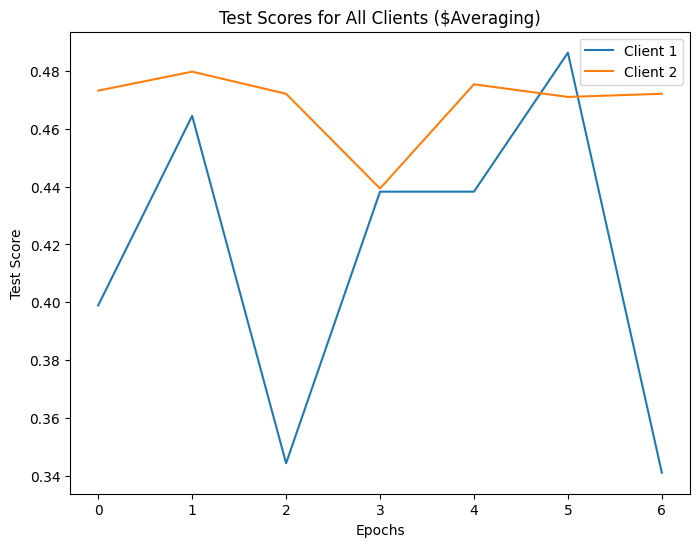

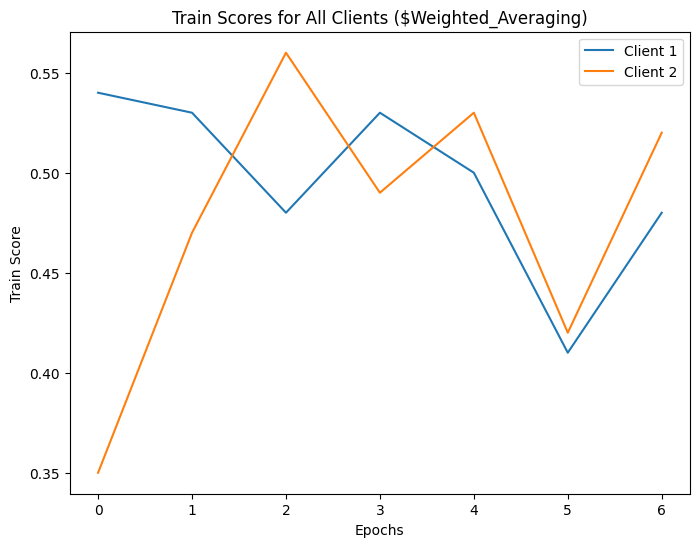

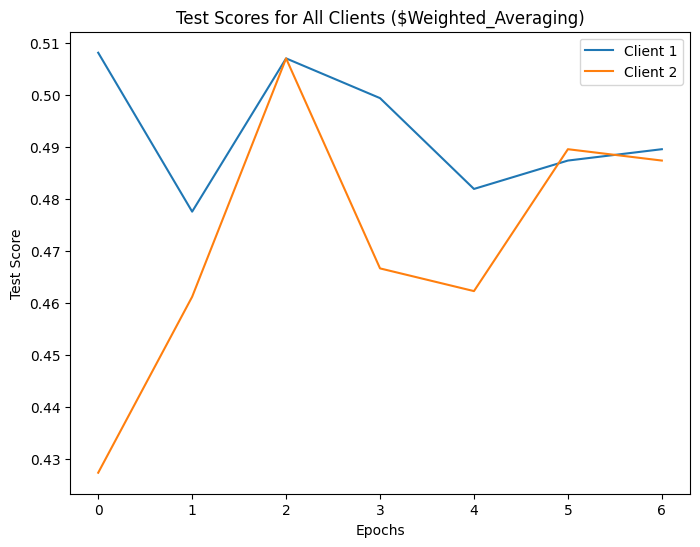

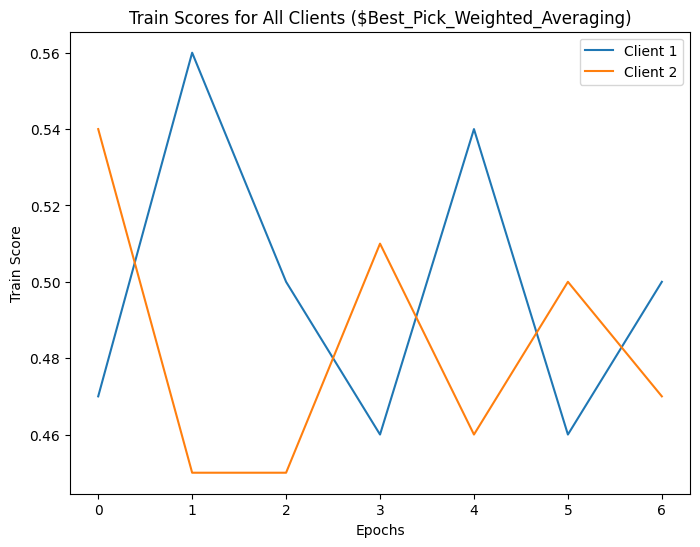

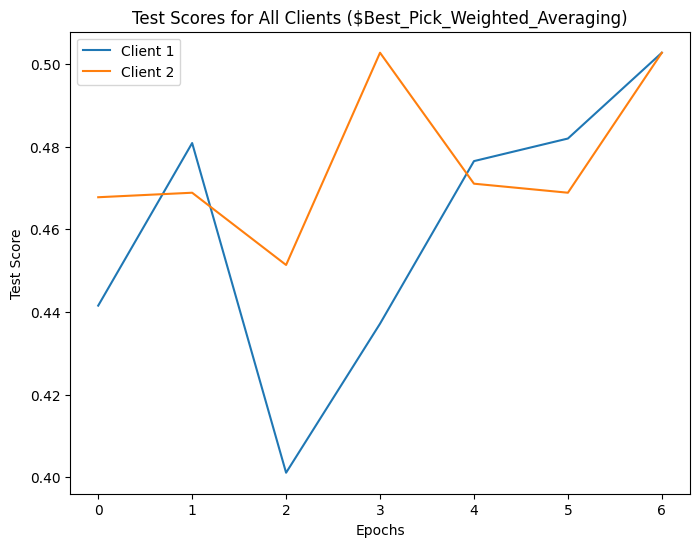

In [41]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores

for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot train scores for all clients
  for client in clients:
      plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Train Score')
  plt.title(f"Train Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the train scores plot
  plt.show()

  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Score')
  plt.title(f"Test Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the test scores plot
  plt.show()


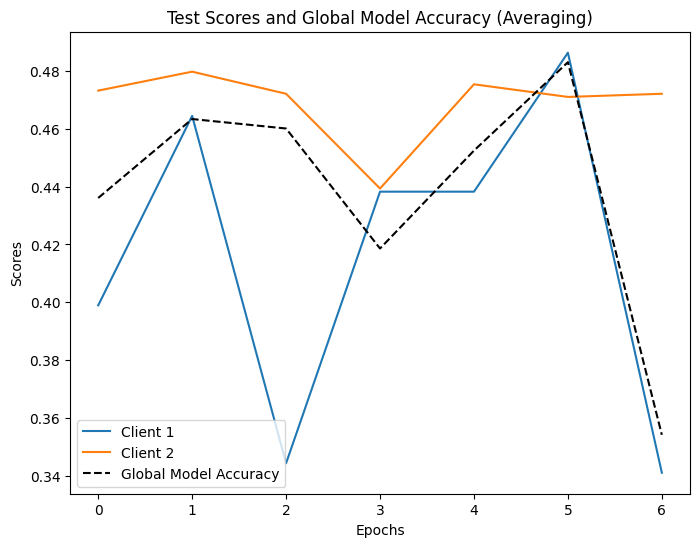

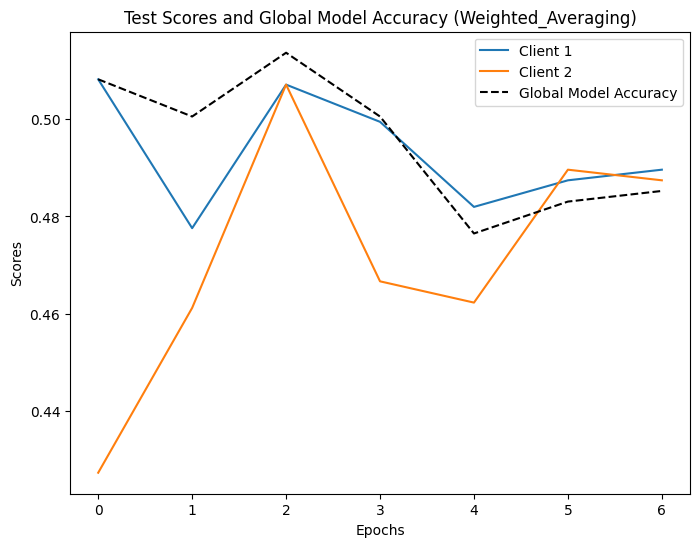

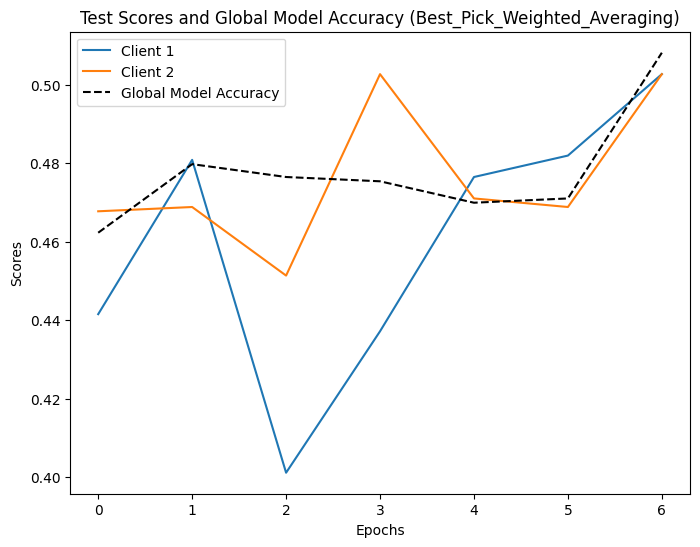

In [42]:
import matplotlib.pyplot as plt


for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))


  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  # Plot global model accuracy
  plt.plot(global_model_accuracy[idx], label='Global Model Accuracy', linestyle='--', color='black')

  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
  plt.legend()

  # Show the combined graph
  plt.show()


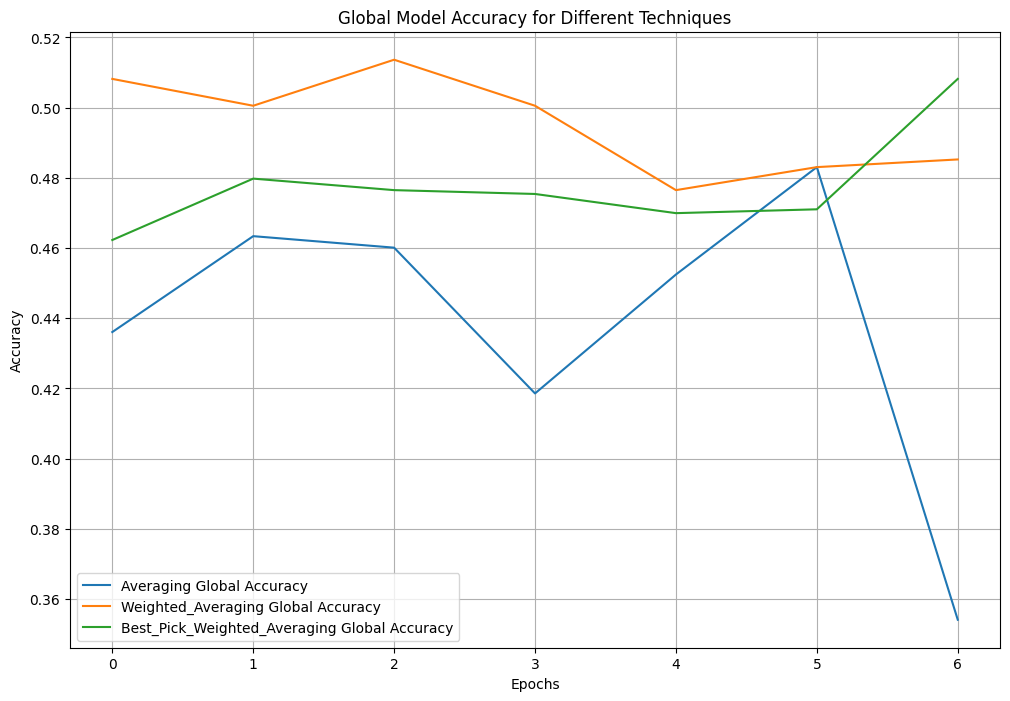